In [2]:
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
%matplotlib inline
from celmech import Andoyer
from tqdm import tqdm
import numpy as np
from celmech.andoyer import get_Hsep
import rebound

In [3]:
params_rv = np.load('stability_posteriors/100k_rv_priors_60mil_lnlike_randomtheta.npy')
preds_rv = np.load('stability_posteriors/100k_rv_stability_preds_randomtheta.npy')

In [4]:
params_rv[0]

array([ 1.52378762e-02,  6.05336544e-03, -4.63498788e+00,  6.60322300e+01,
       -3.22161308e+00,  2.46711955e-01])

In [5]:
m_b_rv = [param[-2] for param in params_rv]
e_b_rv = [param[-1] for param in params_rv]

params_cd = [list(params_rv[i][:4]) for i in range(len(params_rv))]
#deltaTs = [params_rv[i][-2] for i in range(len(params_rv))]

#for p1,p2 in zip(params_cd, deltaTs):
#    p1.append(p2)
    
params_b = [[m_b, e_b] for m_b, e_b in zip(m_b_rv, e_b_rv)]

In [6]:
def makesim(param_cd, param_b, seed, dt=None):
    sim = makesimcd(param_cd[:4], dt=dt)
    
    m_b = 10**param_b[0]
    e_b = param_b[1]
    np.random.seed(seed)
    pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
    theta_b = float(np.random.uniform(0, 2*np.pi, size=1))
    sim.add(m=m_b, P=sim.particles[2].P*1.946, e=e_b, pomega=pomega_b, theta=theta_b)
    sim.move_to_com()
    return sim

def makesimcd(param_cd,dt=None):
    e_forced, e_free, mu, deltaT = param_cd
    if dt:
        deltaT = dt
    mratio=0.5
    e_com = 0.0
    
    Mstar = 1.1
    m1 = mratio*10**mu
    m2 = (1-mratio)*10**mu
    phi = np.pi # where equilibrium is
    theta1 = np.pi # so they start on opposite sides

    andvars = Andoyer.from_Z(j=3, k=1, Z=(e_forced+e_free)/np.sqrt(2), phi=phi, 
                             Zstar=e_forced/np.sqrt(2), Mstar=Mstar, m1=m1, m2=m2, 
                             Zcom=e_com/np.sqrt(2), phiZcom=0, theta1=theta1)

    try:
        sim = andvars.to_Simulation()
        sim.integrator="whfast"
        sim.dt = sim.particles[1].P/20
        sim.ri_whfast.safe_mode = 0
        sim.integrate(deltaT)
        sim.t = 0
        return sim
    except:
        print(e_forced, e_free, deltaT, mu)
        raise

def phi_3body(param_cd, param_b, seed):
    sim = makesim(param_cd, param_b, seed)
    ps = sim.particles
    phi = np.zeros(Nout)
    for i, time in enumerate(times):
        sim.integrate(time)
        phi[i] = ps[1].l - 2*ps[2].l + ps[3].l
    return times, phi

def librates(phi):
    cphi = np.cos(phi)
    Npts = 20
    ranges = np.linspace(-1, 1, Npts)
    librates = False
    for i in range(Npts-1):
        idxs = np.where((cphi>=ranges[i]) & (cphi<=ranges[i+1]))[0]
        if len(idxs) == 0:
            librates = True
            break
    return librates

(<Figure size 360x360 with 1 Axes>, <AxesSubplot:xlabel='x', ylabel='y'>)

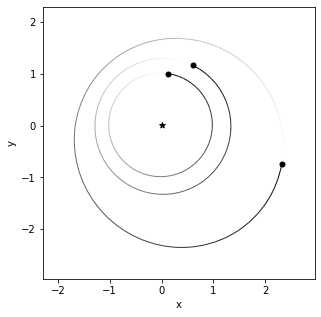

In [7]:
# idx now corresponds to the index AND the seed used when sampling, so pomega_b and theta_b should be the same
idx = 42
#np.random.seed(ctr)
#ctr += 1
pcd = params_cd[idx]
pb = params_b[idx]

sim = makesim(pcd, pb, seed=idx)
rebound.OrbitPlot(sim)

(-1.0, 1.0)

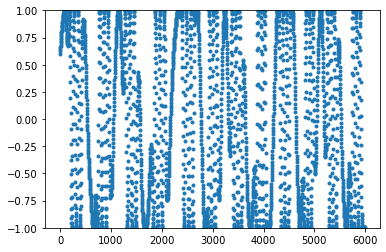

In [8]:
times, phi = phi_3body(pcd, pb, seed=idx)
fig, ax = plt.subplots()
ax.plot(times, np.cos(phi), '.')
ax.set_ylim([-1, 1])

In [9]:
librates(phi)

False

In [10]:
librates(phi_3body(pcd, pb, seed=idx)[-1])

False

## Looping over each configuration, index is seed for $\varpi_b$ and $\theta_b$

In [12]:
librating_arr = []
pbar = tqdm(total=len(params_rv))
for i,(pcd,pb) in enumerate(zip(params_cd, params_b)):
    if i == 66986:
        continue
    libr = librates(phi_3body(pcd, pb, seed=i)[-1])
    librating_arr.append(libr)
    pbar.update()
pbar.close()

  0%|          | 64/100000 [00:08<3:39:10,  7.60it/s]/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/rebound/simulation.py:712: RuntimeWarning: WHFast convergence issue. Timestep is larger than at least one orbital period.
  warnings.warn(msg[1:], RuntimeWarning)
100%|█████████▉| 99999/100000 [3:35:11<00:00,  7.75it/s]  


In [11]:
idx = 78986
librates(phi_3body(params_cd[idx], params_b[idx], seed=idx)[-1])

False

In [22]:
len(librating_arr)

100000

In [16]:
librating_arr.insert(66986, False)

In [18]:
np.save('librating_array.npy',np.array(librating_arr))

In [19]:
np.sum(librating_arr) #omg there are only 5 librating configurations

5

In [48]:
preds_rv[np.where(np.array(librating_arr) == True)]

array([0.01867434, 0.        , 0.06769881, 0.25480133, 0.25662842],
      dtype=float32)

In [49]:
np.sum(preds_rv[np.where(np.array(librating_arr) == True)])/np.sum(preds_rv[preds_rv != 0.0])

0.00020556188

In [31]:
libr_params = params_rv[np.where(np.array(librating_arr) == True)]

In [51]:
libr_index = np.where(np.array(librating_arr) == True)[0]
libr_index

array([ 7045, 27186, 46833, 78901, 84185])

In [60]:
np.array(params_cd)[libr_index]

array([[ 4.80131473e-02,  1.39506522e-02, -4.47535667e+00,
         1.13545543e+03],
       [ 8.56031231e-03,  3.94210101e-03, -4.60597456e+00,
         1.67039763e+03],
       [ 8.20933426e-03,  9.30746160e-03, -4.93993278e+00,
         1.92342047e+03],
       [ 9.81690537e-03,  2.36992614e-03, -4.55276671e+00,
         3.95188112e+02],
       [ 1.39424335e-02,  1.45070708e-02, -4.93011527e+00,
         4.12550605e+02]])

In [64]:
phi_arr = []
times = []
for i,(pcd,pb) in enumerate(zip(np.array(params_cd)[libr_index],np.array(params_b)[libr_index])):
    
    t,phi = phi_3body(params_cd[int(libr_index[i])], params_b[int(libr_index[i])], seed=int(libr_index[i]))
    phi_arr.append(phi)
    times.append(t)

Text(0, 0.5, '3-body resonance angle')

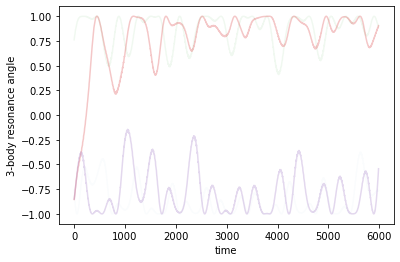

In [68]:
for i,(t, phi) in enumerate(zip(times, phi_arr)):
    plt.plot(t, np.cos(phi), alpha=preds_rv[libr_index][i])

plt.xlabel('time')
plt.ylabel('3-body resonance angle')

In [33]:

def makesim_wb(theta):


    e_forced, e_free, mu, deltaT, mb, eb = theta

    mratio=0.5
    e_com = 0.0
    phiecom=float(np.random.uniform(0, 2*np.pi, size=1)) # varying between 0 and 2pi
    theta1 = np.pi
    Mstar = 1.1
    m1 = mratio*10**mu
    m2 = (1-mratio)*10**mu
    phi = np.pi # where equilibrium is
    theta1 = np.pi # position of planet b

    andvars = Andoyer.from_Z(j=3, k=1, Z=(e_forced+e_free)/np.sqrt(2), phi=phi,
                             Zstar=e_forced/np.sqrt(2), Mstar=Mstar, m1=m1, m2=m2,
                             Zcom=e_com/np.sqrt(2), phiZcom=phiecom, theta1=theta1)

    try:

        sim = andvars.to_Simulation()
        sim.add(m=10**mb, P=sim.particles[2].P*1.946, e=eb, pomega=float(np.random.uniform(0, 2*np.pi, size=1)), 
                theta=float(np.random.uniform(0, 2*np.pi, size=1)))
        sim.integrator="whfast"
        sim.dt = sim.particles[1].P/20
        sim.ri_whfast.safe_mode = 0
        sim.integrate(deltaT)
        sim.t = 0
        return sim
    except KeyboardInterrupt:
        print('Interrupted')
        print(e_forced, e_free, mu, deltaT, mb, eb, pomegab, thetab)
        raise

In [35]:
# last TESS observation:
t_tess = 4664.65

# last K2 observation:
t_K2 = 2265

t = t_tess - t_K2

t_orbits = t/8.24958

#print('Number of orbits between observations: {:.0f}'.format(t_orbits))

t_orb = t_orbits*5.98
tmax = 1.0*t_orb
Nout = 200

t = np.linspace(0,tmax,Nout)
obs_tess = np.where(np.round(abs(t - t_orb),6) == np.round(np.min(abs(t - t_orb)),6))[0][0] 

delta_index = 0
obs_idx=[delta_index,obs_tess+delta_index] # [20, 519] in the current version

nobs = 2
obs_err = np.array([0.0001, 0.0005])
obs = np.array([1.503, 1.503]) 

5it [00:00, 39.01it/s]


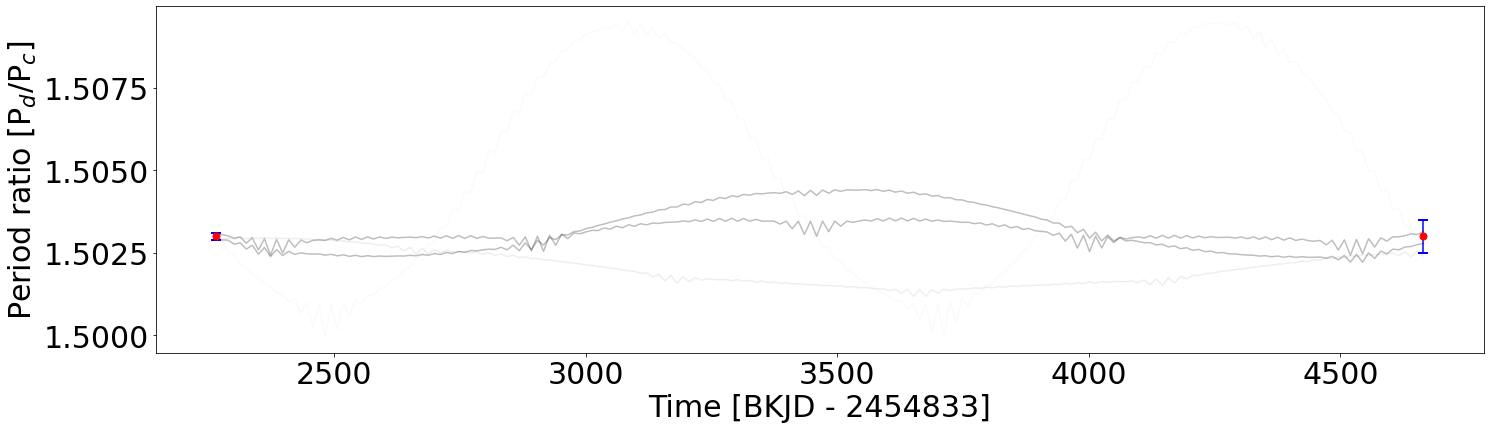

In [46]:
fig = plt.figure(1,figsize=(7*3.4, 2.5*3.4*3/4.))
ax = fig.add_subplot(111)
time_grid = np.linspace(t_K2, t_tess, Nout)

for i,param in tqdm(enumerate(libr_params)):
    #test[1] = ef
    p = param.copy()

    sim = makesimcd(p[:4])
    #megno = sim.calculate_megno()
    ps = sim.particles
    Pratios = np.zeros(Nout)
    for j, time in enumerate(t):

        sim.integrate(time)
        Pratios[j] = ps[2].P/ps[1].P

    ax.plot(time_grid,Pratios,
         alpha=preds_rv[np.where(np.array(librating_arr) == True)][i],zorder=1,c='k',
            #norm=colors.LogNorm(vmin=c_efree.min(), vmax=c_efree.max()),
         rasterized=True)

ax.errorbar(time_grid[[0, -1]],obs,yerr=obs_err, fmt='o',ms=7, c='r',ecolor='b',zorder=1,capsize=5, capthick=2)
ax.set_ylabel('Period ratio [P$_d$/P$_c$]',fontsize=30)
#ax.set_ylim(1.493, 1.510)
ax.set_xlabel('Time [BKJD - 2454833]',fontsize=30)

ax.tick_params(axis='y', labelsize=30)
ax.tick_params(axis='x', labelsize=30)

#t_cbar = fig.colorbar(cmap)
#t_cbar.set_label(r'$e_{\rm{free}}$', fontsize=25)
#t_cbar.ax.tick_params(labelsize=30)
plt.show()
#plt.savefig('figures/Figure2b.pdf',dpi=300,bbox_inches='tight',padding=0)

5it [00:00, 35.76it/s]


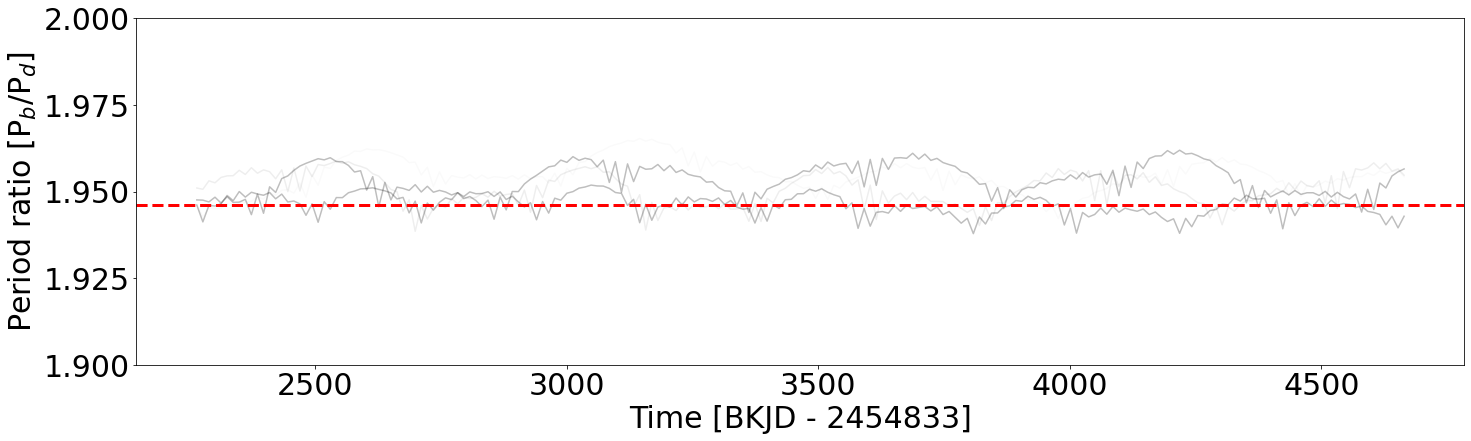

In [37]:
%matplotlib inline
fig = plt.figure(1,figsize=(7*3.4, 2.5*3.4*3/4.))
ax = fig.add_subplot(111)
time_grid = np.linspace(t_K2, t_tess, Nout)

for i,param in tqdm(enumerate(libr_params)):
    p = param.copy()
    #p[-1] = 0.0
    
    sim = makesim_wb(p)
    ps = sim.particles
    Pratios = np.zeros(Nout)
    for j, time in enumerate(t):

        sim.integrate(time)
        Pratios[j] = ps[3].P/ps[2].P
    
    ax.plot(time_grid,Pratios,
         alpha=preds_rv[np.where(np.array(librating_arr) == True)][i],zorder=0, c='k',
         rasterized=True)

#ax1.plot(time_grid, run(makesim(min_mu[0][:4])), c='C2')

#ax.errorbar(time_grid[[0, -1]],obs,yerr=obs_err, fmt='o',ms=7, c='r',ecolor='b',zorder=1,capsize=5, capthick=2)
ax.set_ylabel('Period ratio [P$_b$/P$_d$]',fontsize=30)
ax.set_ylim(1.90, 2.0)
ax.set_xlabel('Time [BKJD - 2454833]',fontsize=30)
ax.axhline(y=1.946, lw=3, ls='--', c='r')

ax.tick_params(axis='y', labelsize=30)
ax.tick_params(axis='x', labelsize=30)
#plt.savefig('figures/Figure2b.pdf',dpi=300,bbox_inches='tight',padding=0)